# **Car Price Prediction**
A complete machine learning project for developing a model for estimating the value of used cars, which includes:

1. *EDA (Exploratory data analysis)*
2. *Data preprocessing*
3. *Model training*
4. *Performance evaluation*

In [ ]:
!pip install fast-ml --quiet;

In [ ]:
import pandas as pd;
import seaborn as sb;
import matplotlib.pyplot as plt;

from keras.models import Sequential;
from keras.layers import Dense, Dropout;
from keras.callbacks import ModelCheckpoint;
from keras.models import load_model;

from sklearn.preprocessing import StandardScaler;
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error;
from fast_ml.model_development import train_valid_test_split;

## 1. Exploratory data analysis (EDA)

Importing cars data from the CSV file:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/cars.csv', index_col=0);
df.head()

,manufacturer,model,body_type,drive_type,transmission_type,engine_capacity,horsepower,fuel_type,mileage,year_of_manufacture,price
0,Mitsubishi,Lancer,Седан,Передній,Ручна / Механіка,1.5,70.0,Бензин,370.0,1988,100
2,Mazda,626,Седан,Передній,Ручна / Механіка,2.0,95.0,Газ / Бензин,388.0,1987,400
8,Mitsubishi,Lancer,Унiверсал,Передній,Ручна / Механіка,1.8,60.0,Дизель,500.0,1988,550
32,Daewoo,Nexia,Седан,Передній,Ручна / Механіка,1.5,75.0,Бензин,138.0,2006,700
37,Opel,Omega,Седан,Задній,Ручна / Механіка,2.0,115.0,Бензин,250.0,1988,700


To detect cars with inadequate attribute values, which can be potential outliers, the following summary statistic has been computed:

In [ ]:
df.describe()

,engine_capacity,horsepower,mileage,year_of_manufacture,price
count,32136.000000,32136.000000,32136.000000,32136.000000,32136.000000
mean,1.949740,148.357284,213.205439,2008.559061,10444.118808
std,0.570734,61.028167,80.629498,5.573107,9513.558789
min,0.900000,42.000000,1.000000,1977.000000,100.000000
25%,1.600000,110.000000,168.000000,2006.000000,5999.000000
50%,1.900000,140.000000,207.000000,2009.000000,8000.000000
75%,2.000000,170.000000,253.000000,2012.000000,11800.000000
max,6.300000,880.000000,999.000000,2021.000000,209966.000000


While it is very unusual for a car to have an engine with capacity as low as 0.9 or as high as 6.3 litres, or horsepower values as low as 91 or as high as 880, it is not entirely unheard of. Therefore, such records have not been removed from the dataset.

Let's check the types of columns and the number of missing values in the dataset:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32136 entries, 0 to 42256
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   manufacturer         32136 non-null  object 
 1   model                32136 non-null  object 
 2   body_type            32136 non-null  object 
 3   drive_type           32136 non-null  object 
 4   transmission_type    32136 non-null  object 
 5   engine_capacity      32136 non-null  float64
 6   horsepower           32136 non-null  float64
 7   fuel_type            32136 non-null  object 
 8   mileage              32136 non-null  float64
 9   year_of_manufacture  32136 non-null  int64  
 10  price                32136 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 2.9+ MB


As can be seen from the output, there are no missing values. There are 2 types of data presented in the dataset:
- categorical: `manufacturer`, `model`, `body_type`, `drive_type`, `transmission_type` and `fuel_type` columns
- numerical: `engine_capacity`, `horsepower`,  `mileage`, `year_of_manufacture` and `price` columns

It is worth noting that all the categories are nominal, which means they can not be ordered or ranked with numbers like 1, 2, 3, etc.

The "strength" of relationships between the target variable `price` and the input numerical variables (`engine_capacity`, `horsepower`,  `mileage` and `year_of_manufacture`) is shown in the correlation matrix below:

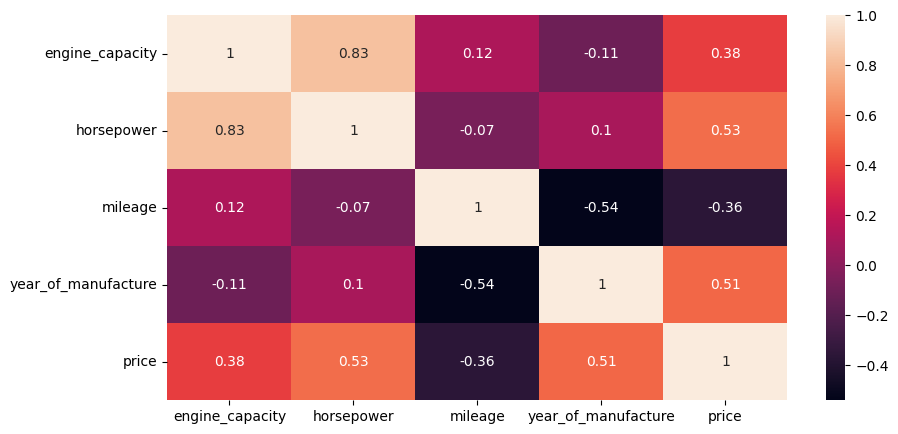

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5));
sb.heatmap(df.corr().round(2), annot=True, ax=ax);

As shown in this matrix, `horsepower` and `year_of_manufacture` are strongly positively correlated with the `price` column.

On the other hand, `engine capacity` and `mileage` have weak positive and negative correlations with the `price`, respectively.

Let's examine the relationships between each pair of variables more closely by drawing the following scatterplots:

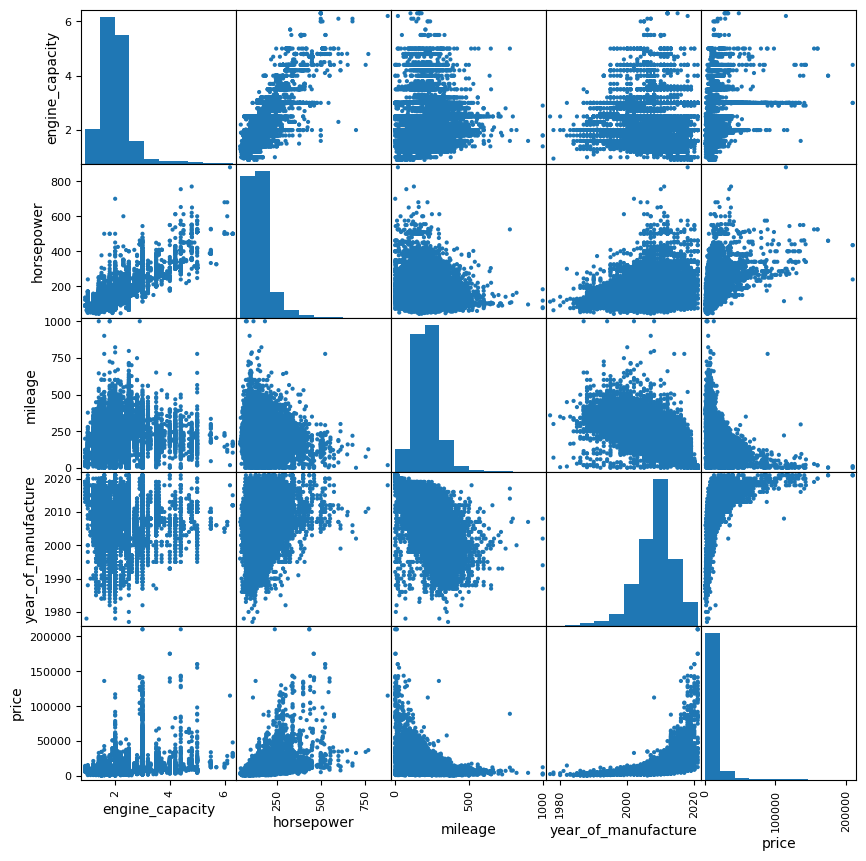

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(10, 10), alpha=1, marker='.');

If we take a closer look at these scatterplots it is evident that the `price` tends to decrease as the `mileage` increases. It makes sense as a car that has been driven extensively tends to be more worn out, resulting in a lower cost.
Similarly, the highest prices correspond to engine capacities between 2 and 5 liters.

Therefore, `mileage` and `engine_capacity` variables have been included in the prediction model.

## 2. Data preprocessing

There are many car models with the same name that belong to different manufacturers, which makes them different from each other:

In [ ]:
df[['manufacturer', 'model']] \
  .groupby('model') \
  .filter(lambda df: df.manufacturer.nunique() > 1) \
  .drop_duplicates() \
  .sort_values(by='model') \
  .head(9)

,manufacturer,model
207,Renault,5
7163,Mazda,5
14493,Dacia,Duster
23224,Renault,Duster
2319,Chevrolet,Lacetti
4867,Daewoo,Lacetti
331,Daewoo,Lanos
653,ЗАЗ,Lanos
2108,Chevrolet,Lanos


To avoid this problem, `manufacturer` and `model` columns have been joined together:

In [ ]:
df.insert(0, 'manufacturer_model', df.manufacturer + " " + df.model);
df = df.drop(columns=['manufacturer', 'model']);
df.head()

,manufacturer_model,body_type,drive_type,transmission_type,engine_capacity,horsepower,fuel_type,mileage,year_of_manufacture,price
0,Mitsubishi Lancer,Седан,Передній,Ручна / Механіка,1.5,70.0,Бензин,370.0,1988,100
2,Mazda 626,Седан,Передній,Ручна / Механіка,2.0,95.0,Газ / Бензин,388.0,1987,400
8,Mitsubishi Lancer,Унiверсал,Передній,Ручна / Механіка,1.8,60.0,Дизель,500.0,1988,550
32,Daewoo Nexia,Седан,Передній,Ручна / Механіка,1.5,75.0,Бензин,138.0,2006,700
37,Opel Omega,Седан,Задній,Ручна / Механіка,2.0,115.0,Бензин,250.0,1988,700


Because all categories are nominal, `One-hot` encoding has been applied for transforming them into numerical data:

In [ ]:
df = pd.get_dummies(df);
df.head()

,engine_capacity,horsepower,mileage,year_of_manufacture,price,manufacturer_model_Acura MDX,manufacturer_model_Audi 100,manufacturer_model_Audi A3,manufacturer_model_Audi A4,manufacturer_model_Audi A5,...,transmission_type_Автомат,transmission_type_Варіатор,transmission_type_Робот,transmission_type_Ручна / Механіка,transmission_type_Типтронік,fuel_type_Бензин,fuel_type_Газ,fuel_type_Газ / Бензин,fuel_type_Гібрид,fuel_type_Дизель
0,1.5,70.0,370.0,1988,100,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,2.0,95.0,388.0,1987,400,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,1.8,60.0,500.0,1988,550,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
32,1.5,75.0,138.0,2006,700,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
37,2.0,115.0,250.0,1988,700,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


The data has been split into `train`, `val` and `test` sets (`80`:`10`:`10` ratio). The numerical columns have been transformed using `Standard scaling` as it is more robust to outliers. 

It is worth mentioning that the `mean` and `standard deviation` used for `Standard scaling` should be computed from the training data to provide unbiased estimations.

In [ ]:
numerical_columns = ['engine_capacity', 'horsepower', 'mileage', 'year_of_manufacture'];
target_column = 'price';

X_train, y_train, X_val, y_val, X_test, y_test = \
  train_valid_test_split(df, target_column, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=1);

scaler = StandardScaler();
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns]);
X_val[numerical_columns]   = scaler.transform(X_val[numerical_columns]);
X_test[numerical_columns]  = scaler.transform(X_test[numerical_columns]);

In [ ]:
X_train.head()

,engine_capacity,horsepower,mileage,year_of_manufacture,manufacturer_model_Acura MDX,manufacturer_model_Audi 100,manufacturer_model_Audi A3,manufacturer_model_Audi A4,manufacturer_model_Audi A5,manufacturer_model_Audi A6,...,transmission_type_Автомат,transmission_type_Варіатор,transmission_type_Робот,transmission_type_Ручна / Механіка,transmission_type_Типтронік,fuel_type_Бензин,fuel_type_Газ,fuel_type_Газ / Бензин,fuel_type_Гібрид,fuel_type_Дизель
32199,0.089598,0.243320,-0.494778,0.613615,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
16160,-0.614697,-0.629791,0.589075,-0.462870,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
18379,0.089598,0.354921,-0.158410,-0.462870,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
24640,-0.614697,-0.400025,-1.640922,0.972443,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
20978,0.089598,0.092331,-1.391760,-0.104042,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


## 3. Neural network training

A feedforward neural network has been utilized for making predictions. It has a standard set of hyperparameter values for a regression task: `ReLU` activation in hidden layers, `Linear` activation in the output neuron, and `Mean squared error` as the loss function. To speed up the training process `Adam` optimization algorithm is used as well as `He_normal` weight initialization. To avoid overfitting `Dropout` layers are placed in between the layers of the network. The hyperparameter values, such as the number of layers, neurons, and dropout rates have been determined empirically.

In [ ]:
model = Sequential([
    Dense(256, activation='relu', kernel_initializer='he_normal', input_dim=len(X_train.columns)),
    Dropout(0.15),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.10),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.05),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.02),
    Dense(1, activation='linear', kernel_initializer='he_normal')
]);

model.compile(optimizer='adam', loss='mse', metrics='mae');
model.build();

model.summary();

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               62464     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)               

After the training, only the version of the model with the lowest validation loss has been saved:

In [ ]:
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True);

history = model.fit(X_train, y_train, epochs=225, batch_size=256, validation_data=(X_val, y_val), callbacks=[model_checkpoint]);

Epoch 1/225
101/101 [==============================] - 6s 22ms/step - loss: 164336240.0000 - mae: 8718.3174 - val_loss: 45717392.0000 - val_mae: 4339.0547
Epoch 2/225
101/101 [==============================] - 2s 18ms/step - loss: 40911160.0000 - mae: 2953.2400 - val_loss: 28809720.0000 - val_mae: 2725.7949
Epoch 3/225
101/101 [==============================] - 2s 17ms/step - loss: 32170868.0000 - mae: 2467.3667 - val_loss: 23082614.0000 - val_mae: 2168.9409
Epoch 4/225
101/101 [==============================] - 2s 18ms/step - loss: 27097426.0000 - mae: 2149.5659 - val_loss: 18557116.0000 - val_mae: 1815.4817
Epoch 5/225
101/101 [==============================] - 2s 18ms/step - loss: 23226466.0000 - mae: 1961.5342 - val_loss: 15758501.0000 - val_mae: 1714.0822
Epoch 6/225
101/101 [==============================] - 3s 30ms/step - loss: 19589738.0000 - mae: 1807.3541 - val_loss: 12617429.0000 - val_mae: 1481.6572
Epoch 7/225
101/101 [==============================] - 2s 22ms/step - loss:

As can be seen in the figure below, the decrease in `Mean absolute error (MAE)` on the training set goes hand in hand with the corresponding decrease on the validation set.

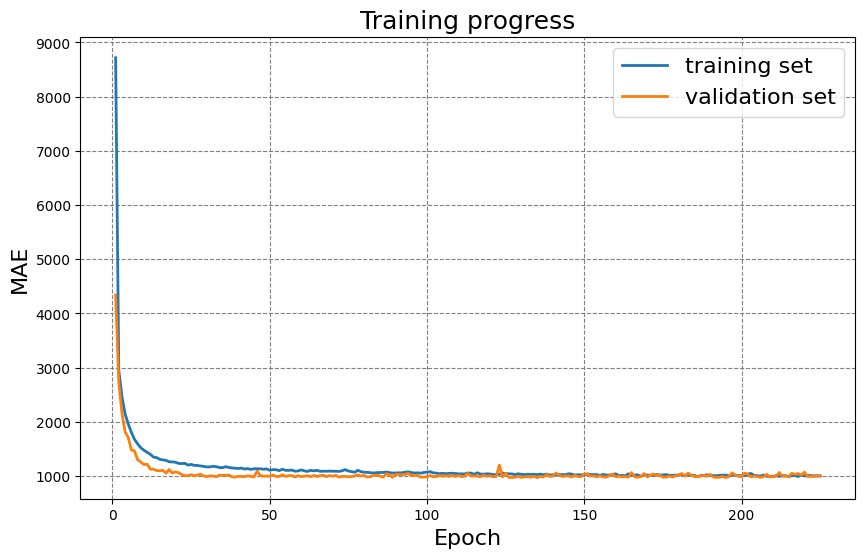

In [ ]:
train_mae = history.history['mae'];
val_mae = history.history['val_mae'];
epochs = range(1, len(train_mae) + 1)

plt.figure(figsize=(10,6));
plt.plot(epochs, train_mae, linewidth=2);
plt.plot(epochs, val_mae, linewidth=2);
plt.title('Training progress', fontsize=18);
plt.xlabel('Epoch', fontsize=16);
plt.ylabel('MAE', fontsize=16);
plt.legend(['training set', 'validation set'], fontsize=16)
plt.grid(color='grey', linestyle='dashed');

## 4. Performance evaluation

To evaluate prediction capabilities of the model, `MAE` and `Coefficient of determination (R2)` metrics have been computed on the testing set:

In [ ]:
model = load_model('/content/model.h5');

y_pred = model.predict(X_test);
print('\nTESTING SET RESULTS:');
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)));
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)));
print('R2 : {}'.format(r2_score(y_test, y_pred)));

101/101 [==============================] - 0s 2ms/step

TESTING SET RESULTS:
MAE: 960.3474375185347
MSE: 2906402.4122980707
R2 : 0.9682686902618477


As can be seen from the `MAE` value of 960 and `R2` value of 0.968, which is very close to one, the model does a pretty good job of estimating car prices. Finally, the predicted and real car prices can be compared in the figure below.

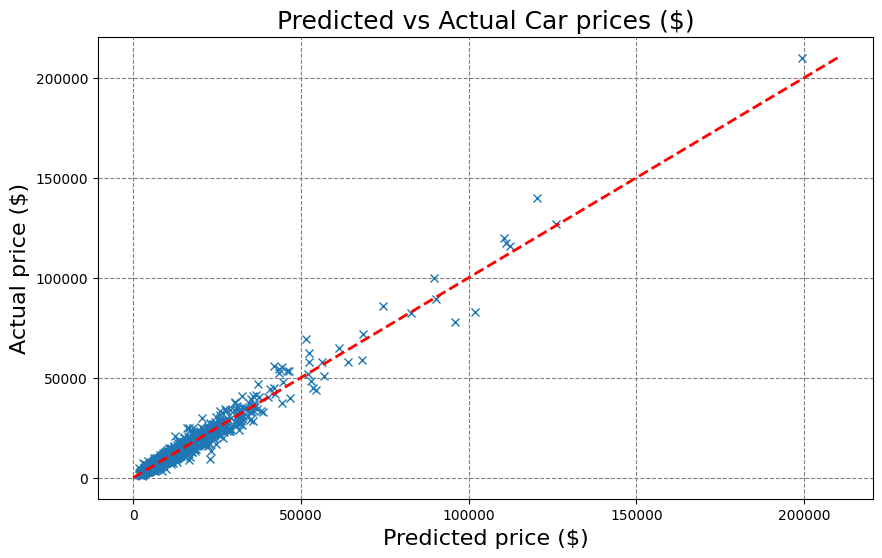

In [ ]:
plt.figure(figsize=(10,6));
plt.plot(y_pred, y_test, 'x');
plt.plot([0, 210000], [0, 210000], 'r--', linewidth=2);
plt.title("Predicted vs Actual Car prices ($)", fontsize=18);
plt.xlabel('Predicted price ($)', fontsize=16);
plt.ylabel('Actual price ($)', fontsize=16);
plt.grid(color='grey', linestyle='dashed');